## File with AIMA functions

In file `search_mod.py` we have some functions implemented by AIMA. To run the code in this notebook, it is needed to run the following cell to import the functions from the file.


In [1]:
# Import implementation of the abstract class that represents a problem to be solved
from search import Problem, Node

# Import search algorithms
from search import depth_first_graph_search, breadth_first_graph_search, astar_search

# Import functions that facilitate the representation of the path to the solution
from aux_functions import path_actions, path_states, run_search_algorithm

## Reading the input


In [2]:
def read_input_file(filename):
    # Read the input file and return the list of lines.
    with open(filename, "r") as file:
        n_rows, n_cols = [int(x) for x in file.readline().split(" ")]

        # Read the map
        map_costs = []

        for _ in range(n_rows):
            map_costs.append([int(x) for x in file.readline().split(" ")])

        # Read the initial and final positions
        initial = tuple([int(x) for x in file.readline().split(" ")])
        goal = tuple([int(x) for x in file.readline().split(" ")])

        return n_rows, n_cols, map_costs, initial, goal


n_rows, n_cols, map_costs, initial, goal = read_input_file("exampleMap.txt")
print(f"Number of rows: {n_rows}")
print(f"Number of columns: {n_cols}")
print(f"Map costs: {map_costs}")
print(f"Initial position: {initial}")
print(f"Goal position: {goal}")

Number of rows: 3
Number of columns: 4
Map costs: [[3, 2, 4, 1], [2, 3, 1, 2], [1, 4, 2, 3]]
Initial position: (0, 3, 0)
Goal position: (1, 2, 8)


## Definition of the problem

We extend the class `Problem` implemented by AIMA to define the problem for this task, called: `MinningProblem`. To achieve this, we define the following methods:

- `__init__(self, initial, goal)`: This method initializes the problem with the initial state and the goal state.
- `is_valid_state(self, state)`: This method checks if a given state is valid, taking into account the number of rows and columns of the problem.
- `actions(self, state)`: This method returns the possible actions that can be taken from a given state. The actions will consists on the next states that can be reached from the current state.
- `result(self, state, action)`: This method returns the state that results from taking an action from a given state (in this case, the action is the next state).
- `h(self, node)`: This method returns the heuristic value of a given node.


In [3]:
class MinningProblem(Problem):
    """We have a board with rows and columns and a robot that can move in 8 directions."""

    def __init__(self, rows, columns, map, initial, goal):
        self.map = map
        self.rows, self.columns = rows, columns
        self.initial, self.goal = initial, goal

    def is_valid_state(self, state):
        """Check that the given state is a possible state given a board with rows and columns."""
        return all(x > 0 for x in state) and state[0] < self.rows and state[1] < self.columns and state[2] < 8

    def actions(self, state):
        """Return the possible movements of the robot given a state"""
        # Get the orientation of the robot
        orientation = state[2]
        # We always can rotate the robot 45 degrees to the left and to the right
        movements = ["turn_left", "turn_right"]
        # The startegy to move forward the robot is to move
        # it always and then check if new_state is valid
        # Calculate the new position on axis y
        new_state = list(state)
        if orientation >= 7 or orientation <= 1:
            new_state[0] = state[0] - 1
        elif orientation >= 3 and orientation <= 5:
            new_state[0] = state[0] + 1
        # Calculate the new position on axis x
        if orientation >= 1 and orientation <= 3:
            new_state[1] = state[1] + 1
        elif orientation >= 5 and orientation <= 7:
            new_state[1] = state[1] - 1

        if self.is_valid_state(new_state):
            movements.append("move_forward")

        return movements

    def result(self, state, action):
        """Move the robot to the next state"""
        if action == "turn_left":
            return (state[0], state[1], (state[2] - 1) % 8)
        elif action == "turn_right":
            return (state[0], state[1], (state[2] + 1) % 8)
        elif action == "move_forward":
            new_state = list(state)
            if state[2] >= 7 or state[2] <= 1:
                new_state[0] = state[0] - 1
            elif state[2] >= 3 and state[2] <= 5:
                new_state[0] = state[0] + 1
            if state[2] >= 1 and state[2] <= 3:
                new_state[1] = state[1] + 1
            elif state[2] >= 5 and state[2] <= 7:
                new_state[1] = state[1] - 1
            return tuple(new_state)
        return action

    def goal_test(self, state):
        """Check if the current state is the goal state"""
        return state[:2] == self.goal[:2]

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1."""
        # We have to distinguish when the state2 is reached by
        # a rotation of the robot or by a movement of the robot
        if action == "turn_left" or action == "turn_right":
            return c + 1
        else:
            return c + self.map[state2[0]][state2[1]]

    def h1(self, node):
        """
        Distance of Mahalanobis between the current state and the goal state.
        To elaborate this heuristic, we supose that all the positions of the board
        has cost 1 and the robot can rotate without cost. Also, we suppose that
        the robot only has to move forward in one axis to reach the goal state.
        """
        return max(abs(self.goal[0] - node.state[0]), abs(self.goal[1] - node.state[1]))

    def h2(self, node):
        """For this heurisit we suppose that all the positions of the board
        has cost 1.
        """
        if self.goal_test(node.state):
            return 0

        orientation = node.state[2]

        movements_y = self.goal[0] - node.state[0]
        movements_x = self.goal[1] - node.state[1]

        # Calculate the directions to move the robot to the goal state
        # in both axis
        orientation_y = 4 if movements_y > 0 else 0
        orientation_x = 2 if movements_x > 0 else 6

        # Calculate absolute values:
        movements_y = abs(movements_y)
        movements_x = abs(movements_x)
        # Calculate the number of movements in diagonal and straight
        diagonal_movements = min(movements_y, movements_x)
        straight_movements = abs(movements_y - movements_x)

        # We have two options: rotate the robot to move diagonally towards
        # the goal state, or rotate the robot to move along the axis where
        # the robot is furthest from the goal state.
        if movements_y > movements_x:
            straight_orientation = orientation_y
        else:
            straight_orientation = orientation_x

        if orientation_y == 0 and orientation_x == 6:  # special case
            diagonal_orientation = 7
        else:
            diagonal_orientation = (orientation_y + orientation_x) // 2

        number_rotations_straight = (
            distance_between_orientations(orientation, straight_orientation) if straight_movements > 0 else 0
        )
        number_rotations_diagonal = (
            distance_between_orientations(orientation, diagonal_orientation) if diagonal_movements > 0 else 0
        )

        number_rotations = max(number_rotations_straight, number_rotations_diagonal)
        total_cost = number_rotations + diagonal_movements + straight_movements

        return total_cost

    def h(self, node):
        return self.h2(node)


def distance_between_orientations(a, b):
    # Calculate the distance between two orientations
    return min((a - b) % 8, (b - a) % 8)

In [4]:
n_rows, n_cols, map_costs, initial, goal = read_input_file("exampleMap.txt")
mp = MinningProblem(n_rows, n_cols, map_costs, initial, goal)
[mp.result(initial, action) for action in mp.actions(initial)]

[(0, 3, 7), (0, 3, 1)]

## Trying the search algorithms


How to use the functions to run the algorithms and representate the followed path in the grid.


In [5]:
sol = breadth_first_graph_search(mp)
print(f"Cost of the solution: {sol.path_cost}")
print(f"Number of actions: {len(path_actions(sol))}")
print(f"Actions: {path_actions(sol)}")
print(f"States: {path_states(sol)}")

Cost of the solution: 4
Number of actions: 4
Actions: ['turn_left', 'turn_left', 'turn_left', 'move_forward']
States: [(0, 3, 0), (0, 3, 7), (0, 3, 6), (0, 3, 5), (1, 2, 5)]


In [9]:
run_search_algorithm(mp, breadth_first_graph_search, verbose=True)

#################################
Running breadth_first_graph_search algorithm
#################################

Path cost: 4

Path actions:
State 0: (0, 3, 0) (initial state)
Action 0: turn_left
State 1: (0, 3, 7)
Action 1: turn_left
State 2: (0, 3, 6)
Action 2: turn_left
State 3: (0, 3, 5)
Action 3: move_forward
State 4: (1, 2, 5)


<Node (1, 2, 5)>

---
# Functions to plot information for the report
---


## Function to find the actions and path obtained with h2

This is only necessary to plot a matrix and the path to write the report


In [98]:
def _h2(state, goal):
    """For this heurisit we suppose that all the positions of the board has cost 1."""

    def is_goal(state):
        return state[:2] == goal[:2]

    if is_goal(state):
        return 0

    orientation = state[2]

    movements_y = goal[0] - state[0]
    movements_x = goal[1] - state[1]

    # Calculate the directions to move the robot to the goal state
    # in both axis
    orientation_y = 4 if movements_y > 0 else 0
    orientation_x = 2 if movements_x > 0 else 6

    # Calculate absolute values:
    movements_y = abs(movements_y)
    movements_x = abs(movements_x)
    # Calculate the number of movements in diagonal and straight
    diagonal_movements = min(movements_y, movements_x)
    straight_movements = abs(movements_y - movements_x)

    # We have two options: rotate the robot to move diagonally towards
    # the goal state, or rotate the robot to move along the axis where
    # the robot is furthest from the goal state.
    if movements_y > movements_x:
        straight_orientation = orientation_y
    else:
        straight_orientation = orientation_x

    if orientation_y == 0 and orientation_x == 6:  # special case
        diagonal_orientation = 7
    else:
        diagonal_orientation = (orientation_y + orientation_x) // 2

    number_rotations_straight = (
        distance_between_orientations(orientation, straight_orientation) if straight_movements > 0 else 0
    )
    number_rotations_diagonal = (
        distance_between_orientations(orientation, diagonal_orientation) if diagonal_movements > 0 else 0
    )

    number_rotations = max(number_rotations_straight, number_rotations_diagonal)
    total_cost = number_rotations + diagonal_movements + straight_movements

    states = [state]

    def move_with_orientation(state, orientation):
        new_state = list(state)
        if orientation == 0:
            new_state[0] = state[0] - 1
        elif orientation == 1:
            new_state[0] = state[0] - 1
            new_state[1] = state[1] + 1
        elif orientation == 2:
            new_state[1] = state[1] + 1
        elif orientation == 3:
            new_state[0] = state[0] + 1
            new_state[1] = state[1] + 1
        elif orientation == 4:
            new_state[0] = state[0] + 1
        elif orientation == 5:
            new_state[0] = state[0] + 1
            new_state[1] = state[1] - 1
        elif orientation == 6:
            new_state[1] = state[1] - 1
        elif orientation == 7:
            new_state[0] = state[0] - 1
            new_state[1] = state[1] - 1
        return (new_state[0], new_state[1], orientation)

    def append_states(state, orientation, movements, states):
        """Function to append the states to the list of states"""
        for _ in range(movements):
            state = move_with_orientation(state, orientation)
            states.append(state)
        return state

    if diagonal_movements == 0:
        if number_rotations_straight > 0:
            states.append((state[0], state[1], straight_orientation))
        state = append_states(state, straight_orientation, straight_movements, states)
    elif straight_movements == 0:
        if number_rotations_diagonal > 0:
            states.append((state[0], state[1], diagonal_orientation))
        state = append_states(state, diagonal_orientation, diagonal_movements, states)
    else:
        if number_rotations_straight < number_rotations_diagonal:
            if number_rotations_straight > 0:
                states.append((state[0], state[1], straight_orientation))  # rotation
            state = append_states(state, straight_orientation, straight_movements, states)
            states.append((state[0], state[1], diagonal_orientation))  # rotation
            state = append_states(state, diagonal_orientation, diagonal_movements, states)
        else:
            if number_rotations_diagonal > 0:
                states.append((state[0], state[1], diagonal_orientation))  # rotation
            state = append_states(state, diagonal_orientation, diagonal_movements, states)
            states.append((state[0], state[1], straight_orientation))
            state = append_states(state, straight_orientation, straight_movements, states)

    return total_cost, states

In [99]:
n_rows, n_cols, map, initial, goal = read_input_file("exampleMap.txt")
sol = run_search_algorithm(mp, breadth_first_graph_search, verbose=False)
h2_cost, states = _h2((1, 1, 3), (2, 3, 8))
states

[(1, 1, 3), (2, 2, 3), (2, 2, 2), (2, 3, 2)]

## Plot the robot and directions

Maybe this is useful to write the explanation of the heuristics in the report. Also it can be used to represent the path followed by the robot with the different search algorithms.


[(0, 0, 0), (0, 0, 2), (0, 1, 2), (0, 1, 3), (1, 2, 3), (2, 3, 3)]


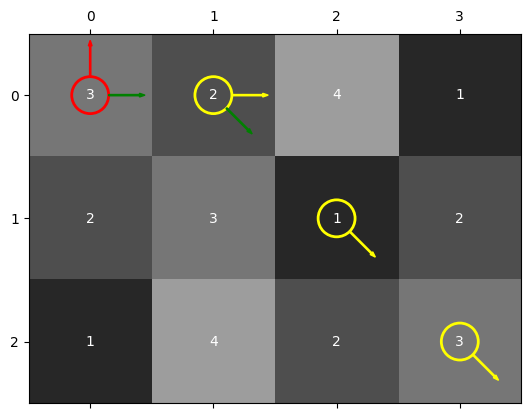

In [102]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Circle, FancyArrow
import numpy as np


def plot_map(map, normalize=True, initial=None, actions=None, states=None):
    fig, ax = plt.subplots()

    # Define the normalization for the colors
    if normalize:
        norm = Normalize(vmin=np.min(map) - 1, vmax=np.max(map) + 2.5)
    else:
        norm = Normalize(vmin=np.min(map), vmax=np.max(map))

    # Plot the map
    cax = ax.matshow(map, cmap="gray", norm=norm)

    # Add the values of the map
    for i in range(map.shape[0]):
        for j in range(map.shape[1]):
            ax.text(j, i, str(map[i, j]), va="center", ha="center", color="white")

    ax.set_xticks(np.arange(map.shape[1]))
    ax.set_yticks(np.arange(map.shape[0]))
    ax.set_xticklabels(np.arange(map.shape[1]))
    ax.set_yticklabels(np.arange(map.shape[0]))

    def calculate_start_end_arrow(state):
        """Auxiliary function to calculate the end of the arrow given a state."""
        orientation = state[2]
        if orientation == 0:
            angle = np.pi / 2
        elif orientation == 1:
            angle = np.pi / 4
        elif orientation == 2:
            angle = 0
        elif orientation == 3:
            angle = -np.pi / 4
        elif orientation == 4:
            angle = -np.pi / 2
        elif orientation == 5:
            angle = -3 * np.pi / 4
        elif orientation == 6:
            angle = np.pi
        elif orientation == 7:
            angle = 3 * np.pi / 4

        radius = 0.15
        start_x = state[1] + radius * np.cos(angle)
        start_y = state[0] - radius * np.sin(angle)

        radius = 0.25
        end_x = radius * np.cos(angle)
        end_y = -radius * np.sin(angle)

        return start_x, start_y, end_x, end_y

    def plot_circle(state, color):
        circle = Circle((state[1], state[0]), 0.15, color=color, fill=False, linewidth=2)
        ax.add_patch(circle)

    def plot_arrow(state, color):
        start_x, start_y, end_x, end_y = calculate_start_end_arrow(state)
        arrow = FancyArrow(
            start_x,
            start_y,
            end_x,
            end_y,
            width=0.01,
            color=color,
        )
        ax.add_patch(arrow)

    # Circle the initial position
    if initial:
        plot_circle(initial, "red")

    # Add the actions
    if states:
        # Plot the initial orientation with a red arrow
        prev_state = states[0]
        plot_arrow(prev_state, "red")
        # Plot the rest of the actions
        for state in states[1:]:
            action = "rotation" if state[2] != prev_state[2] else "move_forward"
            color = "yellow" if action == "move_forward" else "green"
            plot_arrow(state, color)
            if action == "move_forward":
                circle = Circle((state[1], state[0]), 0.15, color=color, fill=False, linewidth=2)
                ax.add_patch(circle)
            prev_state = state

    ax.grid(False)
    plt.show()


n_rows, n_cols, map, initial, goal = read_input_file("exampleMap.txt")
sol = run_search_algorithm(mp, breadth_first_graph_search, verbose=False)
h2_cost, states = _h2((0, 0, 0), (2, 3, 8))
print(states)
plot_map(
    np.array(map),
    initial=states[0],
    states=states,
)